# Introduction

This project set out to decide the best neighborhood in Pittsburgh by combining three metrics: how many acres of park a neighborhood had, how many public art installations it had, and how good its parking was (in terms of parking cost and availability). We generally felt confident in our metrics, and decided on them fairly quickly. Each of our metrics represents an important aspect of life in any neighborhood: healthy access to nature, being able to see human creativity, and, of course, an appropriate transportation situation. Some variation in how to go about representing the best among these metrics was deliberated, though. For example, we considered implementing a graph algorithm to determine *distance* to parks instead of acres of parks within a neighborhood, but eventually scrapped that idea. Also, we had to come up with a way to normalize all of our numerical data in a way that could give us a consolidated series of data that we could analyze for the single best (discussed in the section below). Finally, though, we did determine what we set out to solve: the best neighborhoods in Pittsburgh.

# The Individual Metrics / Analyses

Before combining our metrics to pick the single best neighborhood, we needed to perform our own basic analyses and manipulate our individual datasets. The three individual metrics were:

1. Acres of park (more acres -> better neighborhood)
2. Number of public art installations (more art -> better neighborhood)
3. Rates and availability of metered parking (lower rates, more availability -> better neighborhood)

## Acres of Park

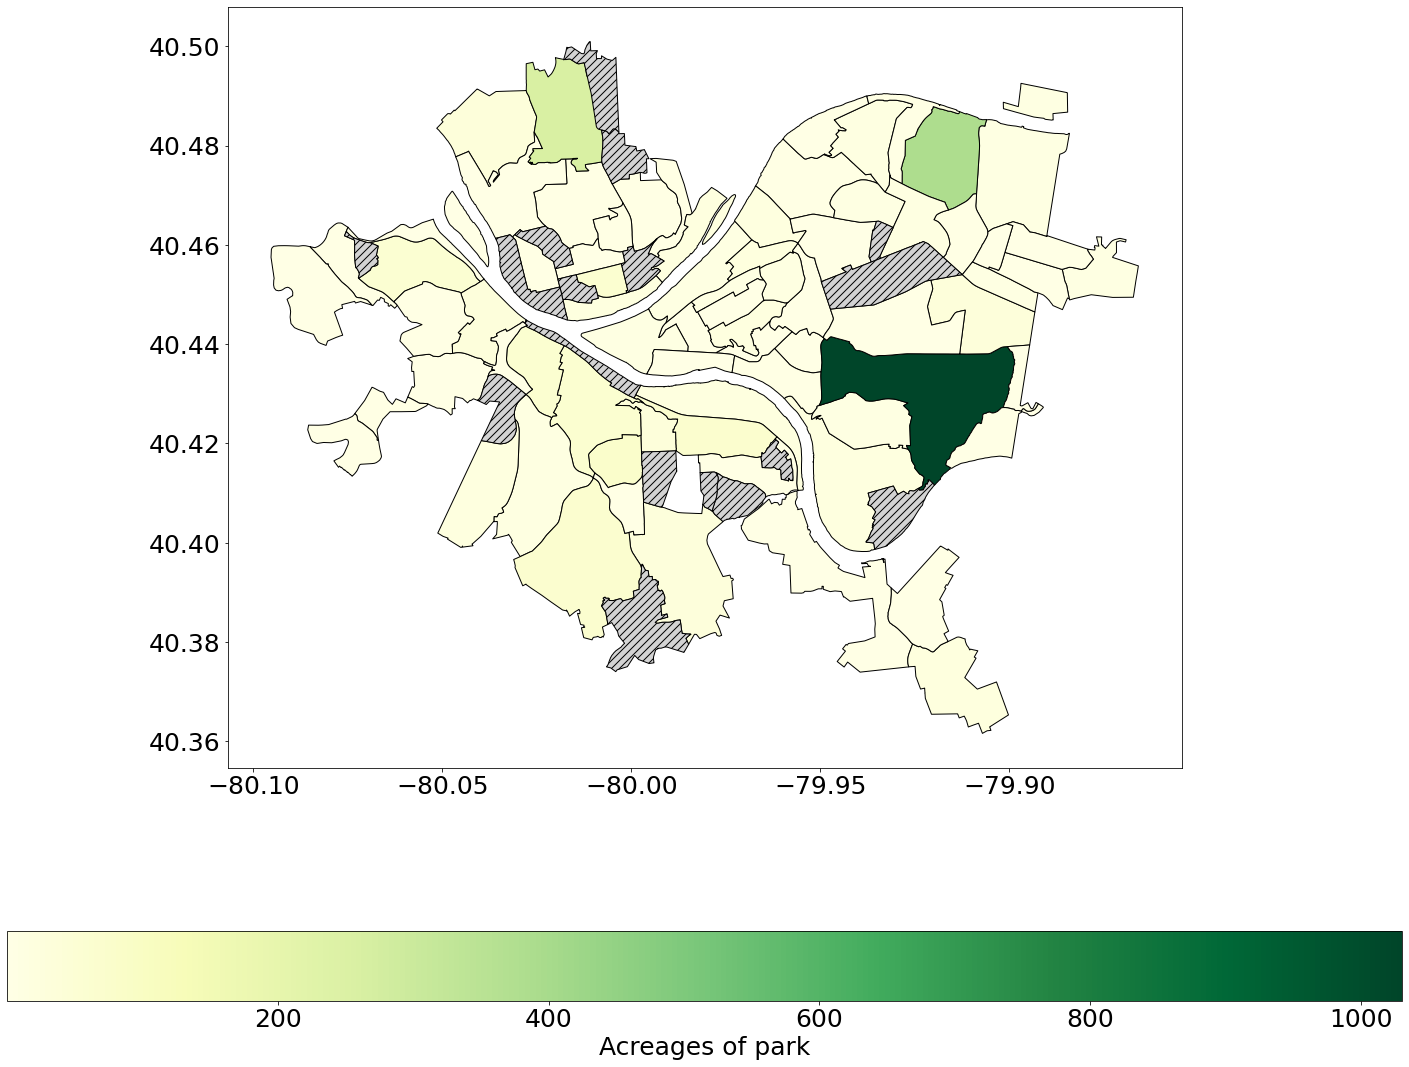

In [37]:
import pandas as pd
import geopandas as gpd
import matplotlib as plt
import sys
%matplotlib inline

# CSV Imports
city_parks = pd.read_csv('datasets/parks/city_parks.csv')
parks = pd.read_csv('datasets/parks/parks.csv')

# Set up font sizes
plt.rc('font', size=25)

# Shapefile imports (used by geopandas to make maps)
parks_shape = gpd.read_file('datasets/parks/Parks.shp')
neighborhoods = gpd.read_file('datasets/neighborhood/Neighborhoods_.shp')

# Merge the dataframes on the park names (which is shared across datasets), 
# we'll use this to eventually group by neighborhood
# and then gather location and area data.
merged_parks = pd.merge(city_parks, parks, on='name')
# Then get the acreage out of those and sort descending, so the neighborhood
# with the highest acreage of park comes out on top.
acreages = merged_parks.groupby('neighborhood')['acreage'].sum().sort_values(ascending=False)

# Finally make a map merging neighborhood information with the acreage information we got from the dataframes.
acres_map_df = neighborhoods.merge(acreages.rename('acreage'), how='left', left_on='hood', right_on='neighborhood')
acres_map = acres_map_df.plot(
               column='acreage',
               cmap='YlGn',
               edgecolor='black', 
               legend=True, 
               legend_kwds={'label':'Acreages of park', 'orientation':'horizontal'}, 
               figsize=(25,20),
               missing_kwds={'color':"lightgrey", "hatch":"///"}
              )

Right off the bat, you can see that there are a few neighborhoods dominating the ring when it comes to access to parks (looking at you, Squirrel Hill South... 👀). Note that neighborhoods that are hatch gray did not have any data.

Out of curiosity, I decided to also overlay the actual locations of the parks themselves onto this heatmap, to better visualise where all that park was that was so clearly defining a winner.

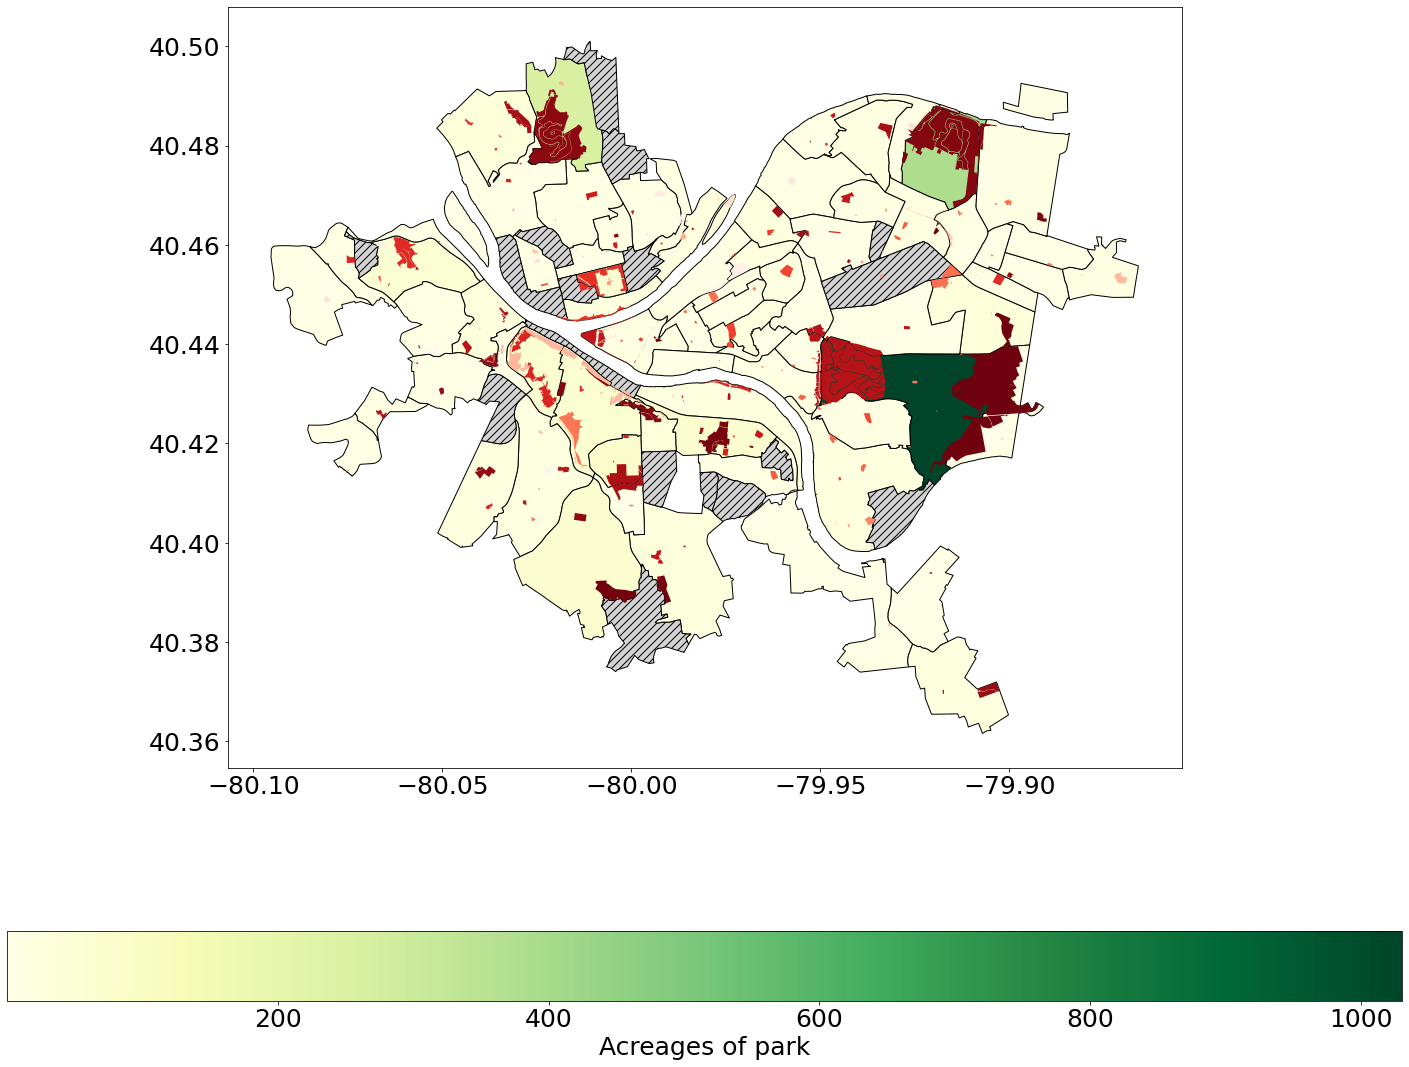

In [38]:
# For some reason in IPython I need to replot the above map before I can plot an overlay onto it.
# This probably has to do with the %matplotlib inline feature.
acres_map = acres_map_df.plot(
               column='acreage',
               cmap='YlGn',
               edgecolor='black', 
               legend=True, 
               legend_kwds={'label':'Acreages of park', 'orientation':'horizontal'}, 
               figsize=(25,20),
               missing_kwds={'color':"lightgrey", "hatch":"///"}
              )
# And here is a map with the actual parks overlayed onto it:
parks_map = parks_shape.plot(ax=acres_map, figsize=(25,20), cmap='Reds')

Something interesting that this map shows, in my opinion, is that neighborhoods that are physically bordering large amounts of park, but who don't include it within their boundaries, are getting a bad rap. This is actually what initially inspired me to roll with the idea of translating each neighborhood into a graph node with an acreage value, with edges that are assigned the physical distance between neighborhoods, then running a graph algorithm to determine the neighborhoods with the most park the *closest*. However, I decided to scrap this idea because--after some consideration--I realized it wouldn't actually change the winner, it would just change the runners up (and it would be pretty difficult to implement; I would have to roll my own graph objects for each neighborhood). 

Now that there is some geographic context to the data, let's lay it out in a way that shows just how wide the margin is between the winning neighborhood and the rest of them:

<AxesSubplot:title={'center':"Share of Pittsburgh's Park Acreage"}, xlabel='neighborhood'>

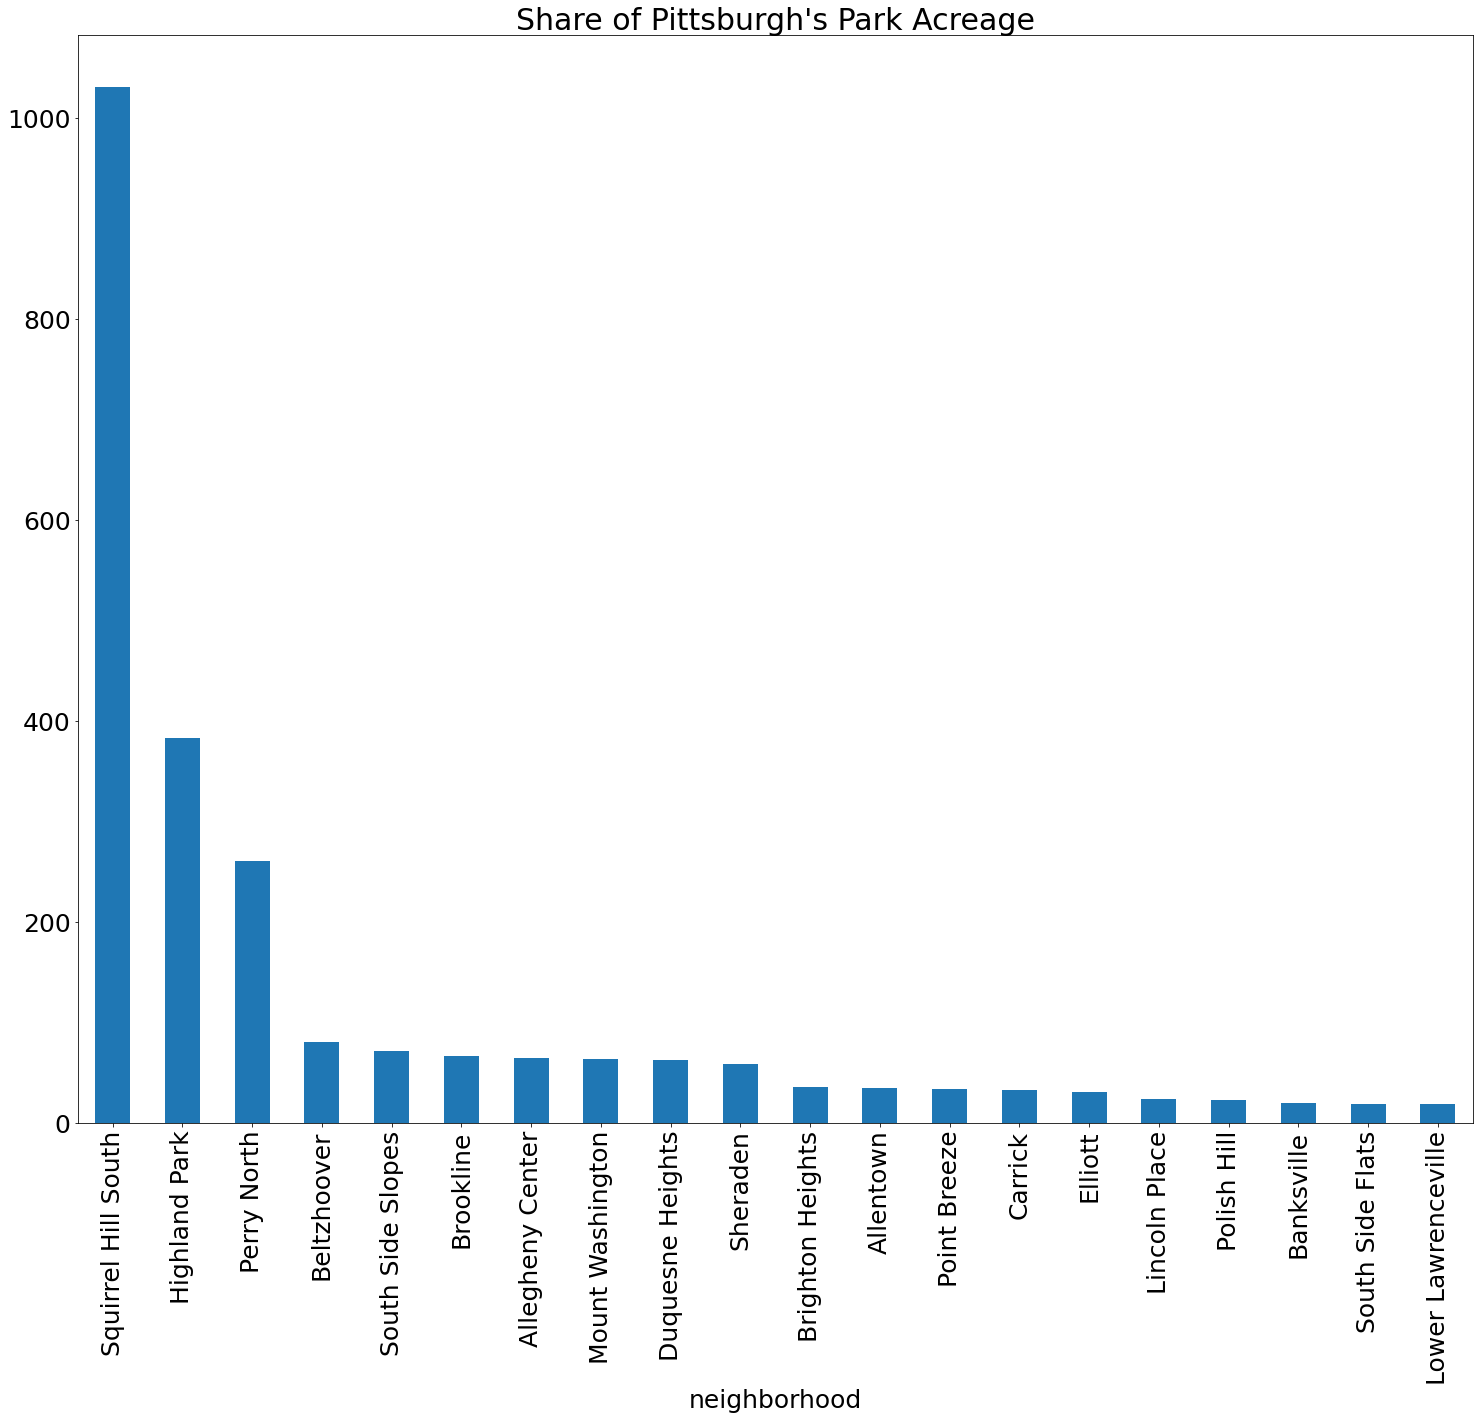

In [39]:
# Note that only the first 20 are shown for brevity, but the trend continues asymptotically down.
acreages.head(20).plot(kind='bar',
                       fontsize=25,
                       x='neighborhood',
                       y='acres',
                       figsize=(25,20),
                       title="Share of Pittsburgh's Park Acreage")

This chart might make it even clearer than the maps do just how much more park Squirrel Hill South has than literally every other neighborhood in Pittsburgh. The next two neighborhoods combined don't even add up to the same amount as Squirrel Hill South. A winner for this metric is, at this point, kind of a given... 

For this metric, **Squirrel Hill South** won, clearly. Here's the top five in table form, anyway:

In [40]:
acreages.head(5)

neighborhood
Squirrel Hill South    1030.808354
Highland Park           383.018646
Perry North             260.202754
Beltzhoover              80.150916
South Side Slopes        71.245957
Name: acreage, dtype: float64

# Parking in Pittsburgh

## Introduction
Everyone that's driven in Pittsburgh knows that finding good parking can be a real pain. Sometimes you can find parking fairly easily but have to pay an arm and a leg for it. Other times you'll be in a relatively cheap area but won't be able to find any spots. And then there's everyone's favorite Pittsburgh Parking Authority that you'll have to deal with if you can't make it back to your spot in time because you had to park out of the way since there were no spots. That's why I wanted to find the best neighborhood for parking in Pittsburgh.

## Metric
To determine the best neighborhood for parking I looked at the average price for parking in each neighborhood and how many metered parking locations there were. I combined these, taking the best in each category, to create a list of the top best neighborhoods for Parking.

## Datasets
I used [Parking Meters Pittsburgh Parking Authority](https://data.wprdc.org/dataset/parking-meters-pittsburgh-parking-authority)'s dataset which includes information on each location's neighborhood, exact location, rate, hours, and other metadata.

In [41]:
import pandas as pd
import geopandas as gpd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Import parking CSV file
# Dataset: Metered parking locations in Pittsburgh
parking = pd.read_csv("./datasets/parking/parking_meters.csv")

# Import shape files for mapping
neighborhoods = gpd.read_file("./datasets/neighborhood/Neighborhoods_.shp")
parking_locs = gpd.read_file("./datasets/parking/pghdb_sde_PPA_ParkingMeters.shp")

# Make the graphs' font size larger
plt.rc('font', size=20)

# Metered Parking Locations in Pittsburgh
This shows a map of all the metered parking locations in Pittsburgh that have been reported by the Pittsburgh Parking Authority marked by blue dots. As you can see there's a pretty nice distribution across Pittsburgh with the most in population hot-spots.

<AxesSubplot:title={'center':'Pittsburgh Parking Locations'}>

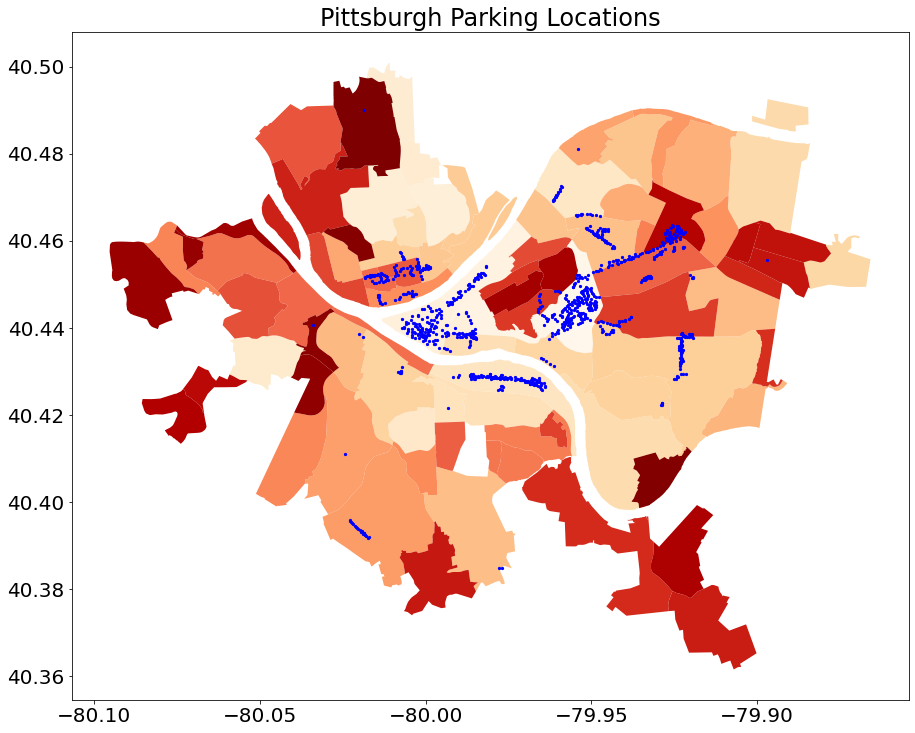

In [42]:
# Map all the parking locations over a map of Pittsburgh
pgh = neighborhoods.plot(cmap="OrRd", figsize=(15, 15))
pgh.set_title("Pittsburgh Parking Locations")
parking_locs.plot(ax=pgh, color="blue", markersize=5)

# Number of Locations per Neighborhood
This is the unfiltered lists of all the neighborhoods in Pittsburgh ranked most parking locations to least. As you can see, there is a huge difference between Oakland in first, and West End in last.

In [43]:
# Count the number of metered parking locations in each neighborhood and sort descending
spots_per_neighborhood = parking.groupby("node").count().sort_values("fid", ascending=False)
# Rename for better readability
spots_per_neighborhood.rename(columns={'fid': 'count'}, inplace=True)
spots_per_neighborhood

,count,objectid,terminal_id,location,terminal_2,rate,latitude,longitude,x,y,...,terminal_3,rate_1,latitude_1,longitud_1,type,location_2,rates,enforcehou,enforeday,pm_zone
node,,,,,,,,,,,,,,,,,,,,,
Oakland,216,216,216,216,216,216,211,211,216,216,...,216,216,211,211,216,216,216,216,216,191
South Side,109,109,109,109,109,109,109,109,109,109,...,109,109,109,109,109,109,109,109,109,108
Downtown,104,104,104,104,104,104,102,102,104,104,...,104,104,99,99,104,104,104,104,104,95
NorthSide,84,84,84,84,84,84,84,84,84,84,...,84,84,84,84,84,84,84,84,84,83
Squirell Hill,69,69,69,69,69,69,68,68,69,69,...,69,69,68,68,69,69,69,69,69,68
ShadySide,66,66,66,66,66,66,65,65,66,66,...,66,66,65,65,66,66,5,5,5,63
Bloomfield,61,61,61,61,61,61,61,61,61,61,...,61,61,61,61,61,61,61,61,61,59
Uptown,60,60,60,60,60,60,60,60,60,60,...,60,60,60,60,60,60,60,60,60,55
East Liberty,59,59,59,59,59,59,59,59,59,59,...,59,59,59,59,59,59,59,59,59,55


# Top Neighborhoods With The Most Locations
These are the top 15 best neighborhoods based solely on the number of metered parking locations. The more locations, the higher the ranking. Oakland takes first by a landslide, having almost twice as many locations as seconds place. However, as we're later see with the prices, location count isn't everything. And as we all know, even with by far the most parking locations, it's still impossible to find parking in Oakland.

In [44]:
# Select the top neighborhoods with the most metered parking locations
top_by_count = spots_per_neighborhood.head(15)
top_by_count

,count,objectid,terminal_id,location,terminal_2,rate,latitude,longitude,x,y,...,terminal_3,rate_1,latitude_1,longitud_1,type,location_2,rates,enforcehou,enforeday,pm_zone
node,,,,,,,,,,,,,,,,,,,,,
Oakland,216,216,216,216,216,216,211,211,216,216,...,216,216,211,211,216,216,216,216,216,191
South Side,109,109,109,109,109,109,109,109,109,109,...,109,109,109,109,109,109,109,109,109,108
Downtown,104,104,104,104,104,104,102,102,104,104,...,104,104,99,99,104,104,104,104,104,95
NorthSide,84,84,84,84,84,84,84,84,84,84,...,84,84,84,84,84,84,84,84,84,83
Squirell Hill,69,69,69,69,69,69,68,68,69,69,...,69,69,68,68,69,69,69,69,69,68
ShadySide,66,66,66,66,66,66,65,65,66,66,...,66,66,65,65,66,66,5,5,5,63
Bloomfield,61,61,61,61,61,61,61,61,61,61,...,61,61,61,61,61,61,61,61,61,59
Uptown,60,60,60,60,60,60,60,60,60,60,...,60,60,60,60,60,60,60,60,60,55
East Liberty,59,59,59,59,59,59,59,59,59,59,...,59,59,59,59,59,59,59,59,59,55


# Average Price Per Neighborhood
Here we calculate the average price of a parking meter in a given neighborhood, and then order them from cheapest to most expensive. As you can see here, Oakland is now coming in third to last. Not looking too good now, is it?

In [45]:
# @param neighborhood = a dataframe containing only one neighborhood's info
# @returns average metered location price for given neighborhood
def calc_avg(neighborhood):
    sum = 0
    for rate in neighborhood:
        sum += float(str(rate).strip("$"))
    return sum / len(neighborhood)

# Replaces missing data with NaN to get dropped by dropna()
parking["node"].replace(' ', np.nan, inplace=True) 

# Call calc_avg on each neighborhood to calculate average meter cost in said neighborhood
avg_neighborhood_price = parking.groupby("node")["rates"].apply(calc_avg).dropna().sort_values().to_frame()
avg_neighborhood_price

,rates
node,
Allentown,1.000000
South Side,1.000000
NorthSide,1.000000
Lawrenceville,1.000000
Mt. Washingt*,1.000000
Brookline,1.000000
Bloomfield,1.000000
Beechview,1.000000
Carrick,1.000000


# Top Cheapest Neighborhoods
Here we take the only neighborhoods where the average parking meter price is less that $1.50. We use this cutoff point since, as seen in the previous data frame, the best 2 averages are $1.00 and $1.50, and anything above that is significantly larger and shouldn't be in consideration for the cheapest neighborhoods. This is where Oakland looses it's gold star.

In [46]:
# Select top cheapest neighborhoods based on average cheapest meter price
top_cheapest_neighborhoods = avg_neighborhood_price.where(avg_neighborhood_price["rates"] <= 1.5).dropna() # Anything above $1.50 is bad

top_cheapest_neighborhoods

,rates
node,
Allentown,1.0
South Side,1.0
NorthSide,1.0
Lawrenceville,1.0
Mt. Washingt*,1.0
Brookline,1.0
Bloomfield,1.0
Beechview,1.0
Carrick,1.0


# Cheapest Neighborhoods With Most Metered Locations
Here we find any neighborhoods that overlap in both most metered parking locations, and best average price, to find the neighborhoods with the overall best parking situations. We then take the top 5 to compare with the other datasets to later conclude on the best neighborhood. A normalized statistic for best parking is also exported here also for use in this later comparison between datasets.

In [47]:
# Perform an inner join on top average cheapest neighborhoods and top neighborhoods with most parking locations
# This finds the overall best neighborhoods base on lowest average parking cost and most locations for parking
best_neighborhoods = top_cheapest_neighborhoods \
    .join(other=top_by_count, how="inner", lsuffix="", rsuffix="_") \
    .sort_values("count", ascending=False)

# Normalized statistic Store/Export for use in group notebook
best_parking = best_neighborhoods / best_neighborhoods.max()
%store best_parking

# Display only the Neighborhood name, rate, and count (number of locations)
best_neighborhoods.head(5)

Stored 'best_parking' (DataFrame)


,rates,count,objectid,terminal_id,location,terminal_2,rate,latitude,longitude,x,...,terminal_3,rate_1,latitude_1,longitud_1,type,location_2,rates_,enforcehou,enforeday,pm_zone
node,,,,,,,,,,,,,,,,,,,,,
South Side,1.0,109,109,109,109,109,109,109,109,109,...,109,109,109,109,109,109,109,109,109,108
NorthSide,1.0,84,84,84,84,84,84,84,84,84,...,84,84,84,84,84,84,84,84,84,83
Squirell Hill,1.5,69,69,69,69,69,69,68,68,69,...,69,69,68,68,69,69,69,69,69,68
Bloomfield,1.0,61,61,61,61,61,61,61,61,61,...,61,61,61,61,61,61,61,61,61,59
Uptown,1.5,60,60,60,60,60,60,60,60,60,...,60,60,60,60,60,60,60,60,60,55


# The Best Parking Locations in Pittsburgh

## Conclusion
The best parking locations in Pittsburgh are South Side, North Side, Squirrel Hill, Bloomfield and Uptown! No big surprise there. Those are some great neighborhoods. We overlay these locations on a map of Pittsburgh so you can see the new distribution of good parking locations and have a point of reference when looking for some parking!

<AxesSubplot:title={'center':'Best Neighborhood Locations'}>

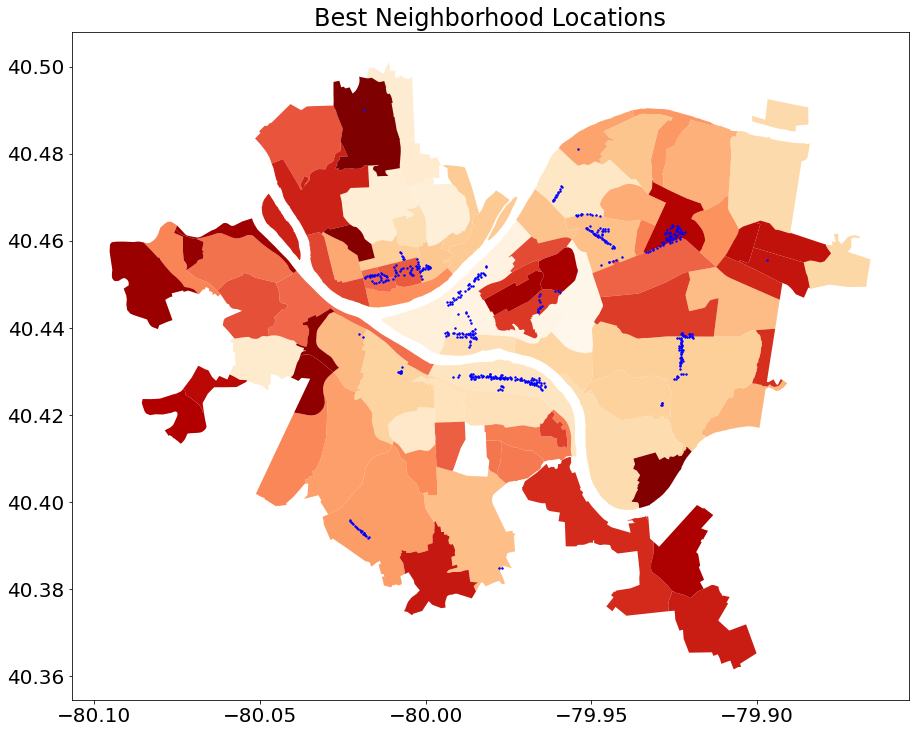

In [48]:
# Perform inner join to select the parking locations from the best neighborhoods
best_locs = parking_locs.join(other=best_neighborhoods, on="node", how="inner", lsuffix="_", rsuffix="__")

# Overlay the parking locations from the best neighborhoods on top of the Pittsburgh map
pgh = neighborhoods.plot(cmap="OrRd", figsize=(15, 15))
pgh.set_title("Best Neighborhood Locations")
best_locs.plot(ax=pgh, color="blue", legend=True, markersize=2)

# Public Art

## Introduction

This dataset looks at the number of public art installations per neighborhood in Pittsburgh.

## Data URL

https://data.wprdc.org/dataset/city-of-pittsburgh-public-art

## Metric

I consider a neighborhood to be "better" if it has more public art installations. After all, who doesn't love art, especially art that you don't have to pay to see? Public art makes a neighborhood more vibrant.

## Code and Visualization

Text(0.5, 1.0, 'Number of Public Art Exhibits in Pittsburgh Neighborhoods')

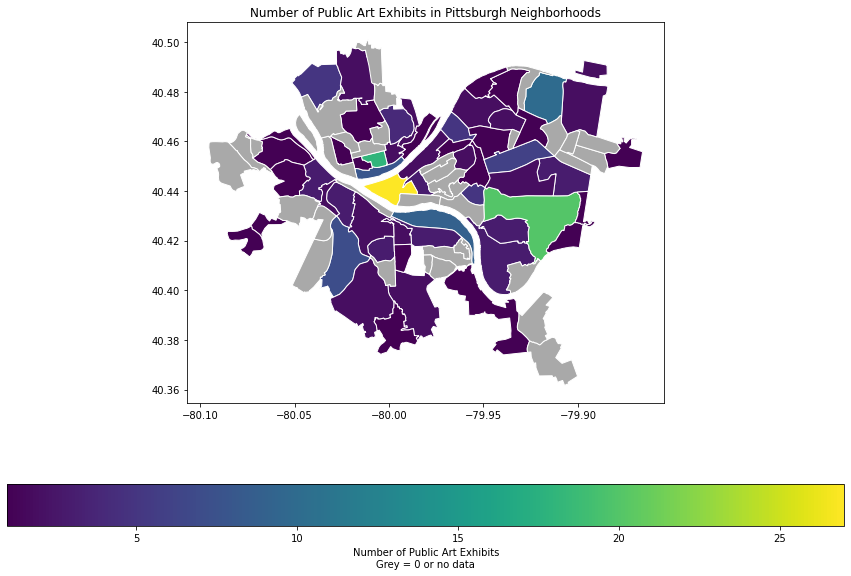

In [9]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gp

# reading from the csv file, grouping and sorting
art = pd.read_csv("./datasets/public-art/public-art.csv")
num_art = art.groupby("neighborhood").size()
num_art.sort_values(ascending=False)

# prepare the neighborhood values from 0 to 1 for use in the combined metric
percent_art = num_art / 27
percent_art = percent_art.sort_values(ascending=False)

# read neighborhood shape file
neighborhoods = gp.read_file("./datasets/neighborhood/Neighborhoods_.shp")

# merge the art info and the shape file to make a cool map 
art_map = neighborhoods.merge(num_art.rename("num_art"), how='left', left_on="hood", right_on='neighborhood')

# display the cool map
art_map.plot(column='num_art', # set the data to be used for coloring
               edgecolor="white",        # outline the districts in white
               legend=True,              # show the legend
               legend_kwds={'label': "Number of Public Art Exhibits\nGrey = 0 or no data", 'orientation': "horizontal"}, # label the legend
               figsize=(15, 10),         # set the size
               missing_kwds={"color": "darkgrey"} # make neighborhoods with no data grey
               ).set_title("Number of Public Art Exhibits in Pittsburgh Neighborhoods") # add title to graph

## Text version of data

In [7]:
print(num_art.sort_values(ascending=False))

neighborhood
Central Business District    27
Squirrel Hill South          20
Allegheny Center             18
Highland Park                10
South Side Flats              9
North Shore                   8
Beechview                     7
Shadyside                     6
Central Oakland               5
Lower Lawrenceville           5
Brighton Heights              5
Spring Hill-City View         4
Point Breeze                  3
Hazelwood                     3
Greenfield                    3
Elliott                       3
Duquesne Heights              3
Beltzhoover                   3
Crawford-Roberts              3
South Side Slopes             3
East Allegheny                2
Garfield                      2
Allentown                     2
Carrick                       2
Brookline                     2
Central Lawrenceville         2
West End                      2
Lincoln-Lemington-Belmar      2
Mount Washington              2
Upper Hill                    2
Strip District             

## Summary

From this data, we can see that the Central Business District is the best neighborhood because of its high number of public art exhibits. Squirrel Hill South, which contains Schenley Park, is a close second. It's not that surprising that downtown Pittsburgh has a lot of art exhibits. A lot of visitors go downtown to see the architecture and attractions like Point State Park, so these art pieces are very visible.

# The (Combined) Metric

To decide the best neighborhood in Pittsburgh, we combined our three individual metrics into one by looking for a neighborhood that covered all of our individual metrics.

The best neighborhood had to be among the neighborhoods with the most acres of park, the most public art installations, and the best parking rates and number of available parking locations.

No neighborhood won all three metrics in first place, so we decided to reduce the data by dividing our outcomes by the max values of each, so that all of our numbers would be reduced to percentages of the highest value. That way, we could combine all of our data without having to worry about the differences in data sizes. Then we added these normalized values up and picked the neighborhood that had the highest sum of these values. 

First, all of the main, manipulated data, needed to apply the reduction formula:
```py
for each dataset:
    for each entry:
        entry /= maximum of dataset
```

Thankfully, with the way mathematical operators can be applied straight to Series and DataFrames in Pandas, this does not need any loops, actually.

In [49]:
reduced_acreage = acreages/acreages.max()
print(reduced_acreage.head(10))

neighborhood
Squirrel Hill South    1.000000
Highland Park          0.371571
Perry North            0.252426
Beltzhoover            0.077755
South Side Slopes      0.069117
Brookline              0.064280
Allegheny Center       0.062001
Mount Washington       0.061419
Duquesne Heights       0.060512
Sheraden               0.056878
Name: acreage, dtype: float64


neighborhood
Squirrel Hill South    1.000000
Highland Park          0.371571
Perry North            0.252426
Beltzhoover            0.077755
South Side Slopes      0.069117
Name: acreage, dtype: float64


<AxesSubplot:title={'center':'Neighborhoods with most Acres of Park'}, xlabel='neighborhood'>

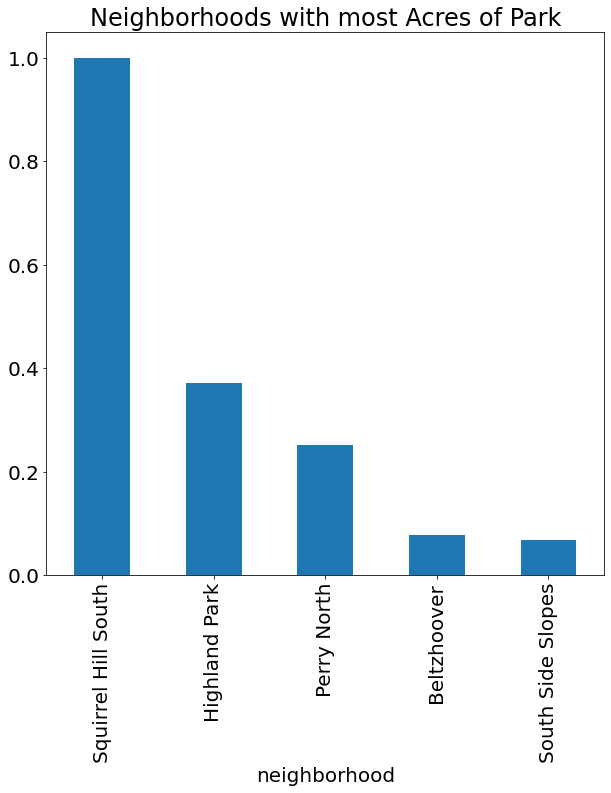

In [50]:
# There is no need to reimport anything here, as the kernel runs as if
# all code cells were in the same interpreter session.
print(reduced_acreage.head(5))
reduced_acreage.head(5).plot(kind='bar', title="Neighborhoods with most Acres of Park", figsize=(10,10))

neighborhood
Central Business District    1.000000
Squirrel Hill South          0.740741
Allegheny Center             0.666667
Highland Park                0.370370
South Side Flats             0.333333
dtype: float64


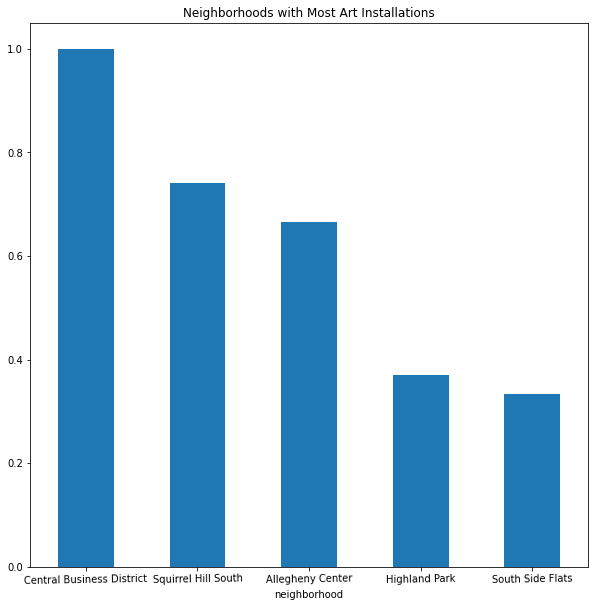

In [10]:
print(percent_art.head(5))
percent_art.head(5).plot(kind='bar', title="Neighborhoods with Most Art Installations", rot=True, figsize=(10,10))

node
South Side       0.833333
Squirell Hill    0.816514
Uptown           0.775229
East Liberty     0.770642
Strip Distri*    0.729358
Name: combined, dtype: float64


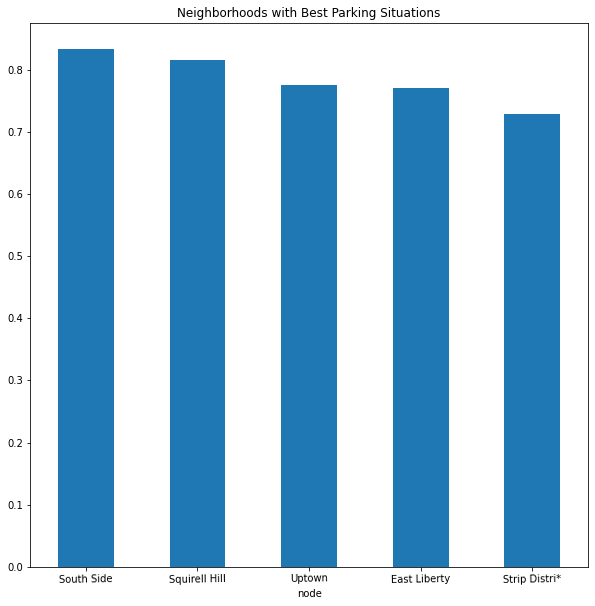

In [ ]:
%store -r best_parking

# Combine the parking rates and parking locations data and average, row-wise
best_parking['combined'] = best_parking[['rates', 'count']].astype(float).mean(axis=1)

print(best_parking['combined'].sort_values(ascending=False).head(5))
best_parking['combined'].sort_values(ascending=False).head(5).plot(kind='bar', title="Neighborhoods with Best Parking Situations", rot=True, figsize=(10,10))

Squirrel Hill South          1.740741
Central Business District    1.008461
South Side                   0.833333
East Liberty                 0.819641
Squirell Hill                0.816514
dtype: float64


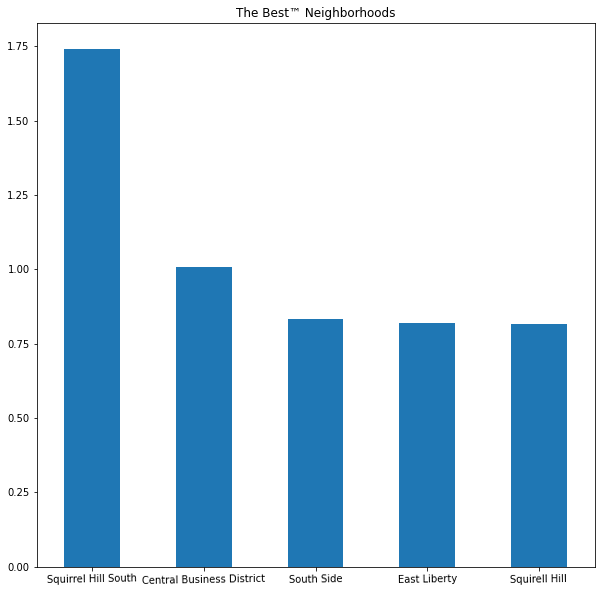

In [ ]:
# THIS IS NOT HOW WE SHOULD LEAVE THIS, LET'S MAKE A **STACKED** GRAPH OF ALL OF THE VALUES
best_neighborhoods = (reduced_acreage.add(percent_art, fill_value=0).add(best_parking['combined'], fill_value=0)).sort_values(ascending=False).head(5)
print(best_neighborhoods)
best_neighborhoods.plot(kind='bar', title="The Best™ Neighborhoods", rot=True, figsize=(10,10))

Note that due to a naming convention difference across a couple of datasets, Squirrel Hill was separated into two separately named neighborhoods here. But, thankfully, it doesn't affect the outcome, because adding the values of the different variations of Squirrel Hill together still results in a clear winner. Speaking of which...

# The Best Neighborhood

So, after all of that, which is the best? 

Drumroll please ... 🥁

**Squirrel Hill South!**

# Conclusions
***THIS PART IS NOT FINISHED***

 *Gavin's response:* Personally, I agreed with the outcome of this analysis. I remember spending a lot of time in Squirrel Hill (namely the parks, of course!) as a kid. I think that having access to nature like that is good for people, especially young, developing people and families. There is ample research available to show that access to nature has several benefits to people's overall health. Despite how much access to nature means to me personally, this aspect of a neighborhood was weighted equally to the other aspects we inspected according to our percentage-based algorithm, and yet the neighborhood that won this category managed to take the final win as well. Personally I think it goes to show that neighborhoods which excel in one quality will tend to excel in others, as well. Taking a slight deviation into the philosophical, this reflects the intertwined, systemic nature of both wealth and poverty. A neighborhood that is wealthy enough to afford many acres of park might also be wealthy enough to invest in better education and housing, and might attract more businesses, thereby creating more jobs, *thereby reducing crime, violence, and increasing wealth in a feedback loop.* This concept is why I think that it is important to be system-critical in analyses like this, to look at several different aspects of a system and closely examine how they interact. In this way, I appreciate what this analysis did: it combined several seemingly unrelated data points and looked at a neighborhood more as a whole. Who would have thought that more parks correlated with better parking at all?

 *Collin's response:* I agree that Squirrel Hill is the best neigborhood in Pittsburgh. Between all of the parks, parking, and public art that Squirrel Hill offers, it is a very nice, welcoming, and relatively clean neighborhood that's always a good time. It's also a popular destination for college students, possibly including myself, for after graduation. With most of Pittsburgh being a so-called concrete jungle, an abundance of parks in Squirrel Hill really makes a difference and puts it above it's competitors. Not only do parks help the environment by cleaning the air and giving a place for nature to flourish, but they are also great community centers. One of my favorite parts of the springtime is when everyone starts spending more time outside after hiding away for the winter months. Parks are a great place for this, and Squirrel Hill has plenty. Adding to the hospitable environment of Squirrel Hill is also the public art. Local areas supporting art is always a great reflection of what the surrounding community is like. Public art shows a sense of community and culture, and helps paint a history for a location. Take the St. Louis Arch for example. This giant piece of public art is a major landmark and tourist hotspot that brings people from all over together, while at the same time displaying a message of community for St. Louis. Squirrel Hill's public art does the same. Tying both of these important components of Squirrel Hill together is the parking. Without good parking, it would be difficult to spend time in this wonderful neighborhood and become a part of it's community. Luckily parking has nothing on Squirrel Hill. While I myself haven't had to park there, when I do visit, I can confirm that it does seem to have a good parking situation. On top of all this, Squirrel Hill is home to Napoli Pizza, which is honestly the final dealbreaker over all the other neighborhoods if you ask me!
 
 *Sean's response:* I totally agree with our final outcome. Squirrel Hill is an awesome neighborhood. I'm new to Pittsburgh, having come from Virginia, but I've seen enough of Squirrel Hill to know that it is a quality place to hang out, and probably to live. The neighborhood has a lot of park space, which is great for everyone to get out, get some exercise, and touch some grass. This is important because it gives its residents and residents of surrounding areas space to recharge and reconnect with nature after a long day of serving the capitalist machine. Of course, I also like Squirrel Hill because of its abundance of public art exhibits. It's nice to see a neighborhood that is so involved in creating a vibrant, livable space for its residents. Public art is a great attraction for folks who may not have the money to get into museums or other paid attractions. Finally, I can appreciate how good the parking situation is in Squirrel Hill. I've only driven around Pittsburgh a handful of times, but each time I learn that parking can be quite a challenge in an urban environment like Pittsburgh. That's why I value Squirrel Hill and its high ranking for parking. It's nice to be able to find a spot, and even nicer to not have to spend an arm and a leg on parking. Overall, with its focus on the arts and nature, and its quality parking, Squirrel Hill is a neighborhood that I'd love to live in.